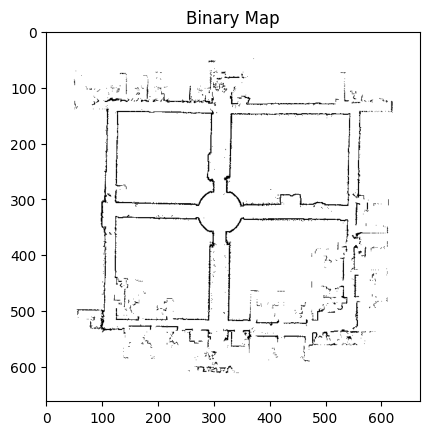

In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
def preprocess_map(image_path, output_path):
    image = cv2.imread(image_path)
    hsv = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)
    lower_green, upper_green = np.array([35, 50, 50]), np.array([90, 255, 255])
    mask = cv2.inRange(hsv, lower_green, upper_green)
    image[mask > 0] = [255, 255, 255]
    cv2.imwrite(output_path, image)
preprocess_map("aces_relations.png", "processed_map.png")
map_image = cv2.imread("processed_map.png", cv2.IMREAD_GRAYSCALE)
_, binary_map = cv2.threshold(map_image, 200, 255, cv2.THRESH_BINARY)
plt.imshow(binary_map, cmap="gray")
plt.title("Binary Map")
plt.show()

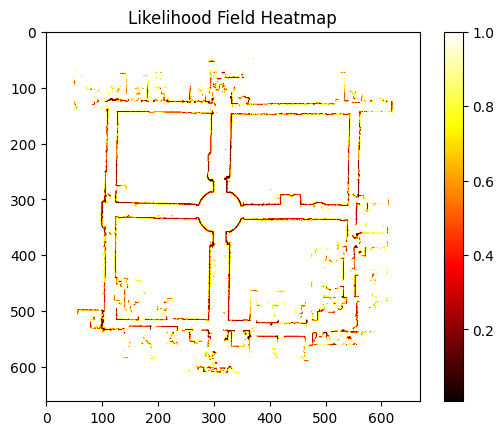

In [2]:
def precompute_likelihood_fields(map_image):
    _, binary_map = cv2.threshold(map_image, 200, 255, cv2.THRESH_BINARY)
    binary_map = (binary_map == 0).astype(np.uint8)
    distance = cv2.distanceTransform(binary_map, cv2.DIST_L2, 5)
    max_dist = np.max(distance)
    likelihood_fields = np.exp(-distance / (max_dist * 0.2 + 1e-6))
    plt.imshow(likelihood_fields, cmap="hot")
    plt.colorbar()
    plt.title("Likelihood Field Heatmap")
    plt.show()
    return likelihood_fields
likelihood_fields = precompute_likelihood_fields(map_image)

In [3]:
def parse_aces_clf(file_path):
    odom_readings = []
    flaser_readings = []
    with open(file_path, "r") as f:
        for line in f:
            tokens = line.strip().split()
            if not tokens:
                continue
            elif tokens[0] == "FLASER":
                num_readings = int(tokens[1])
                scan_values = list(map(float, tokens[2:num_readings+2]))
                odom_x, odom_y, odom_theta = map(float, tokens[num_readings+5:num_readings+8])
                odom_readings.append({"x": odom_x, "y": odom_y, "theta": odom_theta})
                flaser_readings.append({"scan": scan_values, "x": odom_x, "y": odom_y, "theta": odom_theta})
    return odom_readings, flaser_readings
odom_data, flaser_data = parse_aces_clf("aces.clf")

In [4]:
odom_data

[{'x': -0.000602, 'y': 0.012727, 'theta': -1.570796},
 {'x': -0.000602, 'y': 0.012727, 'theta': -1.570796},
 {'x': -0.000602, 'y': 0.012727, 'theta': -1.570796},
 {'x': -0.000602, 'y': 0.012727, 'theta': -1.570796},
 {'x': -0.000602, 'y': 0.012727, 'theta': -1.570796},
 {'x': -0.000602, 'y': 0.012727, 'theta': -1.570796},
 {'x': -0.000602, 'y': 0.012727, 'theta': -1.570796},
 {'x': -0.000602, 'y': 0.012727, 'theta': -1.570796},
 {'x': -0.000602, 'y': 0.012727, 'theta': -1.570796},
 {'x': -0.000602, 'y': 0.012727, 'theta': -1.570796},
 {'x': -0.000602, 'y': 0.012727, 'theta': -1.570796},
 {'x': -0.000602, 'y': 0.012727, 'theta': -1.570796},
 {'x': -0.000602, 'y': 0.012727, 'theta': -1.570796},
 {'x': -0.000602, 'y': 0.012727, 'theta': -1.570796},
 {'x': -0.000602, 'y': 0.012727, 'theta': -1.570796},
 {'x': -0.000602, 'y': 0.012727, 'theta': -1.570796},
 {'x': -0.000602, 'y': 0.012727, 'theta': -1.570796},
 {'x': -0.000602, 'y': 0.012727, 'theta': -1.570796},
 {'x': -0.000602, 'y': 0.012

In [5]:
def predict_pose(odom_prev, odom_curr):
    dx = odom_curr["x"] - odom_prev["x"]
    dy = odom_curr["y"] - odom_prev["y"]
    dtheta = odom_curr["theta"] - odom_prev["theta"]
    x_pred = odom_prev["x"] + dx
    y_pred = odom_prev["y"] + dy
    theta_pred = odom_prev["theta"] + dtheta
    return {"x": x_pred, "y": y_pred, "theta": theta_pred}

In [6]:
def lidar_to_cartesian(scan, x, y, theta, scale=0.1, origin=(316, 139)):
    points = []
    for i, d in enumerate(scan):
        angle = theta + (i * np.pi / len(scan)) - np.pi / 2
        x_world = x + d * np.cos(angle)
        y_world = y + d * np.sin(angle)
        x_pixel = int(origin[0] + x_world * scale)
        y_pixel = int(origin[1] - y_world * scale)
        points.append((x_pixel, y_pixel))
    return points

In [7]:
def correlate_scan(likelihood_fields, scan_points):
    scan_points = np.array(scan_points, dtype=int)  # Convert all points to integers
    valid_mask = (0 <= scan_points[:, 0]) & (scan_points[:, 0] < likelihood_fields.shape[1]) & \
                 (0 <= scan_points[:, 1]) & (scan_points[:, 1] < likelihood_fields.shape[0])
    valid_points = scan_points[valid_mask]
    likelihood_values = likelihood_fields[valid_points[:, 1].astype(int), valid_points[:, 0].astype(int)]
    return np.sum(np.exp(-likelihood_values ** 2 / (2 * (0.1 ** 2))))

In [8]:
def fuse_odometry_csm(odom_pred, csm_corrected, alpha=0.8):
    x_fused = alpha * odom_pred["x"] + (1 - alpha) * csm_corrected["x"]
    y_fused = alpha * odom_pred["y"] + (1 - alpha) * csm_corrected["y"]
    theta_fused = alpha * odom_pred["theta"] + (1 - alpha) * csm_corrected["theta"]
    return {"x": x_fused, "y": y_fused, "theta": theta_fused}

In [ ]:
def global_localization(odom_data, flaser_data, likelihood_fields):
    best_positions = []
    for i in range(1, len(flaser_data)):
        scan_data = flaser_data[i]
        odom_prev = odom_data[i - 1]
        odom_curr = odom_data[i]
        height, width = likelihood_fields.shape[:2]
        odom_pred = predict_pose(odom_prev, odom_curr)
        scan_points = lidar_to_cartesian(scan_data["scan"], odom_pred["x"], odom_pred["y"], odom_pred["theta"])
        for i, (x, y) in enumerate(scan_points):
            if not (0 <= x < likelihood_fields.shape[1] and 0 <= y < likelihood_fields.shape[0]):
                print(f" Out of bounds: Point {i}: ({x}, {y})")
        best_score = correlate_scan(likelihood_fields, scan_points)
        best_pose = odom_pred
        for dx in np.linspace(-2, 2, 7):
            for dy in np.linspace(-2, 2, 7):
                for dtheta in np.linspace(-np.pi/6, np.pi/6, 7):
                    candidate_pose = {
                        "x": odom_pred["x"] + dx,
                        "y": odom_pred["y"] + dy,
                        "theta": odom_pred["theta"] + dtheta
                    }
                    perturbed_points = lidar_to_cartesian(scan_data["scan"], candidate_pose["x"], candidate_pose["y"], candidate_pose["theta"])
                    score = correlate_scan(likelihood_fields, perturbed_points)
                    if score > best_score:
                        best_score = score
                        best_pose = candidate_pose
        final_pose = fuse_odometry_csm(odom_pred, best_pose)
        best_positions.append(final_pose)
    return best_positions
best_positions = global_localization(odom_data, flaser_data, likelihood_fields)

In [ ]:
for i, pos in enumerate(best_positions[:10]):
    print(f"Step {i}: x={pos['x']:.2f}, y={pos['y']:.2f}, theta={pos['theta']:.4f}")

In [ ]:
def parse_aces_relations(file_path):
    relations = []
    with open(file_path, "r") as f:
        for line in f:
            tokens = line.strip().split()
            if len(tokens) == 8:
                relations.append({"x": float(tokens[2]), "y": float(tokens[3]), "yaw": float(tokens[7])})
    return relations
relations_data = parse_aces_relations("aces.relations")

In [ ]:
def estimate_noise_params(relations_data):
    return {k: (np.mean([r[k] for r in relations_data]), np.std([r[k] for r in relations_data])) for k in ["x", "y", "yaw"]}
noise_params = estimate_noise_params(relations_data)
noise_params

In [ ]:
def visualize_scan_on_map(scan_points, map_image):
    map_copy = map_image.copy()
    for px, py in scan_points:
        if 0 <= px < map_copy.shape[1] and 0 <= py < map_copy.shape[0]:
            map_copy[py, px] = 128
    plt.imshow(map_copy, cmap="gray")
    plt.title("LiDAR Scan")
    plt.show()
scan_points = lidar_to_cartesian(flaser_data[0]["scan"], flaser_data[0]["x"], flaser_data[0]["y"], flaser_data[0]["theta"])
visualize_scan_on_map(scan_points, map_image)